In [1]:
import splitfolders

In [2]:
input_folder = 'raw-img'
output = 'splits'

splitfolders.ratio(input_folder, output, seed=42, ratio=(.6, .2, .2))

In [3]:
!pip install --upgrade --force-reinstall scipy

  Using cached scipy-1.8.0-cp39-cp39-macosx_12_0_arm64.whl (28.7 MB)
  Using cached numpy-1.22.3-cp39-cp39-macosx_11_0_arm64.whl (12.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.0
    Uninstalling scipy-1.8.0:
      Successfully uninstalled scipy-1.8.0


In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf

In [10]:
img_height, img_width = (256, 256)
batch_size = 32

train_data = 'splits/train'
test_data = 'splits/test'
val_data = 'splits/val'

In [11]:
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)

train_generator = train_data_gen.flow_from_directory(train_data, 
                                                     target_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     subset='training')

valid_generator = train_data_gen.flow_from_directory(val_data, 
                                                     target_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     subset='validation')

Found 4313 images belonging to 4 classes.
Found 1021 images belonging to 4 classes.


In [12]:
test_generator = train_data_gen.flow_from_directory(test_data, 
                                                    target_size=(img_height, img_width),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 1008 images belonging to 4 classes.


In [13]:
x, y = test_generator.next()
x.shape

(1, 256, 256, 3)

In [14]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator, epochs = 10)

Epoch 1/10
135/135 [==============================] - 159s 1s/step - loss: 0.2334 - accuracy: 0.9423
Epoch 2/10
135/135 [==============================] - 161s 1s/step - loss: 0.0415 - accuracy: 0.9856
Epoch 3/10
135/135 [==============================] - 163s 1s/step - loss: 0.0311 - accuracy: 0.9893
Epoch 4/10
135/135 [==============================] - 167s 1s/step - loss: 0.0333 - accuracy: 0.9893
Epoch 5/10
135/135 [==============================] - 167s 1s/step - loss: 0.0252 - accuracy: 0.9896
Epoch 6/10
135/135 [==============================] - 166s 1s/step - loss: 0.0331 - accuracy: 0.9882
Epoch 7/10
135/135 [==============================] - 168s 1s/step - loss: 0.0118 - accuracy: 0.9963
Epoch 8/10
135/135 [==============================] - 169s 1s/step - loss: 0.0097 - accuracy: 0.9961
Epoch 9/10
135/135 [==============================] - 170s 1s/step - loss: 0.0098 - accuracy: 0.9970
Epoch 10/10
135/135 [==============================] - 166s 1s/step - loss: 0.0260 - accura

In [15]:
model.save('ResNet50_animals.h5')

/Users/Brad/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

1008/1008 - 80s - loss: 0.0484 - accuracy: 0.9851 - 80s/epoch - 79ms/step

Test accuracy: 0.9851190447807312


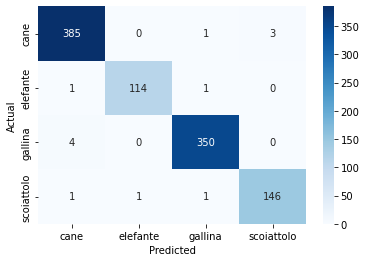

test acc: 98.71031746031747


In [17]:
model = tf.keras.models.load_model('ResNet50_animals.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()

for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
conf_mat = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(conf_mat, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test acc: {}'.format((np.diagonal(conf_mat).sum()/conf_mat.sum().sum()*100)))